In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from sklearn import metrics as sk_metrics
import pickle
import time
import math

C:\Users\why\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Part 1: Read Data

In [2]:
np.set_printoptions(precision=4, threshold=np.inf)

In [3]:
aftershock_threshold = 1

In [4]:
file_path = './Data/days_after_mainshock_360/'

In [5]:
feat_columns = ['aftershock_mag', 'sxx', 'syy', 'szz', 'syz', 'sxz', 'sxy', 'coulomb', 'maxshear', 'von']

In [6]:
add_self, add_sqrt, add_abs, add_physic, add_log = False, False, True, True, True

In [7]:
def get_filename(filepath = file_path):
    file_list = []
    for filename in os.listdir(filepath):
        file_list.append(filename)
    return file_list
file_list = get_filename()
print(len(file_list))

175


In [8]:
mag_range = [3.0, 5.0, 5.5, 6.0, 8.0]
dis_range = [0, 20, 40, 60, 100000]

In [9]:
tmp = pd.read_csv(file_path+file_list[0],index_col=0)
print(tmp.columns)

Index(['x', 'y', 'mainshock_mag', 'aftershock_mag', 'sxx', 'syy', 'szz', 'syz',
       'sxz', 'sxy', 'coulomb', 'maxshear', 'von'],
      dtype='object')


In [10]:
def get_sample(file_list, col_list, filepath=file_path, add_self=add_self, add_sqrt=add_sqrt, add_abs=add_abs, 
               add_physic=add_physic,add_log=add_log):
    new_col = ['aftershock_mag']
    if add_self:
        for col in col_list[1::]:
            new_col.append(col)
    if add_abs:
        for col in col_list[1::]:
            if col in ['sxx', 'syy', 'szz', 'syz', 'sxz', 'sxy']:
                new_col.append("abs_"+col)
#                 new_col.append("-abs_"+col)
    if add_sqrt:
        for col in col_list[1::]:
            if col in ['sxx', 'syy', 'szz', 'syz', 'sxz', 'sxy']:
                new_col.append("sqrt_"+col)
                
    if add_physic:
        for col in col_list[1::]:
            if col in ['coulomb', 'maxshear', 'von']:
                new_col.append('abs_'+col)
#                 new_col.append('-abs_'+col)
    if add_log:
        for col in col_list[1::]:
            if col in ['sxx', 'syy', 'szz', 'syz', 'sxz', 'sxy']:
                new_col.append("log_"+col)
#                 new_col.append("-log_"+col)
    raw_data = None  
    for file in file_list:
        main_Mag = float(file.strip('.csv').split('-')[1][1::])
        df = pd.read_csv(filepath+file, header=0)
        axis = np.where(np.isnan(df))
        if len(axis[0]) != 0:
            print("%s is wrong" % file)
            continue
        unique = df['aftershock_mag'].unique()
        if(len(unique)==1):
            continue
        
        index = len(df.columns)
        columns = df.columns.copy()
        for col in columns:
            df.insert(index, '-'+col, -df[col])
            df.insert(index+1, 'abs_'+col, abs(df[col]))
            df.insert(index+2, '-abs_'+col, -abs(df[col]))
            col_sqrt = df[col].apply(lambda x: math.sqrt(abs(x)))
            df.insert(index+3, 'sqrt_'+col, col_sqrt)
            df.insert(index+4, '-sqrt_'+col, -col_sqrt)
            col_log = df[col].apply(lambda x: np.log(abs(x)+1))
            df.insert(index+5, 'log_'+col, col_log)
            df.insert(index+6, '-log_'+col, -col_log)
            
        for idx in range(len(mag_range) - 1):
            if main_Mag >= mag_range[idx] and main_Mag < mag_range[idx+1]:
                break
        mainMag_oneHot = [[0]*(len(mag_range)-1)]
        mainMag_oneHot[0][idx] = 1
        mainMag_oneHot = mainMag_oneHot * len(df)
        index = len(df.columns)
        mainMag_oneHot = np.array(mainMag_oneHot)
        for idx in range(len(mag_range)-1):
            df.insert(index+idx, 'mainMag_oneHot_'+str(idx), mainMag_oneHot[:, idx])
        
        dis_oneHot = []
        for x, y in zip(df['x'].values, df['y'].values):
#             print(x, y)
            dis = math.sqrt(x*x + y*y)
            for idx in range(len(dis_range)-1):
                if dis >= dis_range[idx] and dis < dis_range[idx+1]:
                    break
            dis_oneHot_tmp = [0]*(len(dis_range)-1)
            dis_oneHot_tmp[idx] = 1
            dis_oneHot.append(dis_oneHot_tmp)

        index = len(df.columns)
        dis_oneHot = np.array(dis_oneHot)
        for idx in range(len(dis_range)-1):
            df.insert(index+idx, 'dis_oneHot_'+str(idx), dis_oneHot[:, idx])
        if raw_data is None:
            raw_data = df
        else:
            raw_data = raw_data.append(df)
    
    if raw_data is None:
        return raw_data
    if len(raw_data) == 0:
        return raw_data[new_col]

    for idx in range(len(mag_range)-1):
        new_col.append('mainMag_oneHot_'+str(idx))
    for idx in range(len(dis_range)-1):
        new_col.append('dis_oneHot_'+str(idx))
    
    raw_data = raw_data[new_col]
    return raw_data

In [11]:
raw_data = get_sample(file_list[0:5], feat_columns, file_path, add_self=add_self, add_sqrt=add_sqrt, add_abs=add_abs, add_physic=add_physic)

In [12]:
print(raw_data.columns)

Index(['aftershock_mag', 'abs_sxx', 'abs_syy', 'abs_szz', 'abs_syz', 'abs_sxz',
       'abs_sxy', 'abs_coulomb', 'abs_maxshear', 'abs_von', 'log_sxx',
       'log_syy', 'log_szz', 'log_syz', 'log_sxz', 'log_sxy',
       'mainMag_oneHot_0', 'mainMag_oneHot_1', 'mainMag_oneHot_2',
       'mainMag_oneHot_3', 'dis_oneHot_0', 'dis_oneHot_1', 'dis_oneHot_2',
       'dis_oneHot_3'],
      dtype='object')


# Part 2. Model

In [13]:
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\why\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [14]:
# def generate_data(POSdata, NEGdata, batch_size, posstart, negstart):
#     shapepos = np.shape(POSdata)
#     shapeneg = np.shape(NEGdata)
#     np.random.shuffle(POSdata)
#     np.random.shuffle(NEGdata)
#     while 1:
#         if posstart + round(batch_size/2.) >= shapepos[0]: 
#             posstart = 0
#             np.random.shuffle(POSdata)
#         posend = posstart + int(round(batch_size/2.))
#         if negstart + round(batch_size/2) >= shapeneg[0]: 
#             negstart = 0
#             np.random.shuffle(NEGdata)
#         negend = negstart + int(round(batch_size/2.))       
#         data = np.row_stack((POSdata[posstart:posend,:], NEGdata[negstart:negend,:]))
#         np.random.shuffle(data)
#         posstart = posstart + int(round(batch_size/2.))
#         negstart = negstart + int(round(batch_size/2.))
#         yield (data[:,1:-1], data[:,0], data[:, -1])        

In [15]:
def generate_data(POSdata, NEGdata, batch_size, posstart, negstart):
    shapepos = np.shape(POSdata)
    shapeneg = np.shape(NEGdata)
    np.random.shuffle(POSdata)
    np.random.shuffle(NEGdata)
    ratio = round(shapeneg[0] / shapepos[0])
#     ratio = 1
    batch_posCnt = round(batch_size / (1 + ratio))
    batch_negCnt = batch_size - batch_posCnt
    while 1:
        if posstart + batch_posCnt >= shapepos[0]: 
            posstart = 0
            np.random.shuffle(POSdata)
        posend = posstart + batch_posCnt
        if negstart + batch_negCnt >= shapeneg[0]: 
            negstart = 0
            np.random.shuffle(NEGdata)
        negend = negstart + batch_negCnt       
        data = np.row_stack((POSdata[posstart:posend,:], NEGdata[negstart:negend,:]))
        np.random.shuffle(data)
        posstart = posstart + batch_posCnt
        negstart = negstart + batch_negCnt
        yield (data[:,1:-1], data[:,0], data[:, -1])     #   feat, label, weight       


In [16]:
class Args(object):
    def __init__(self):
        self.lr = 0.1
        self.train_batch_size = 128 * 2
        self.eval_batch_size = 128
        self.test_batch_size = 128
        self.num_epoch = 100
        self.drop_rate = 0.5
        self.feat_size = (len(raw_data.columns) - 1)
        self.hidden_units = [64]*5
        self.embedding_size = 16
        self.max_grad_norm = 5.

In [17]:
class model(object):
    def __init__(self, is_training, args):
        self.train_batch_size = args.train_batch_size
        self.eval_batch_size = args.eval_batch_size
        self.test_batch_size = args.test_batch_size
        self.num_epoch = args.num_epoch
        self.drop_rate = args.drop_rate
        
        self.hidden_units = args.hidden_units
        self.max_grad_norm = args.max_grad_norm
        self.lr = args.lr
        
        self.embedding_size = args.embedding_size
        self.feat_size = args.feat_size
        
        self.input_data = tf.placeholder(tf.float32, [None, self.feat_size])
        self.targets = tf.placeholder(tf.float32, [None])
        self.sample_weight = tf.placeholder(tf.float32, [None])
        
        seed=1
        with tf.variable_scope("Embedding_Mag", reuse=tf.AUTO_REUSE):
            embedding_mag = tf.get_variable("embedding_mag", [len(mag_range)-1, self.embedding_size],
                                             initializer=tf.random_normal_initializer(seed=seed))
                                           
        with tf.variable_scope("Embedding_Dis", reuse=tf.AUTO_REUSE):
            embedding_dis = tf.get_variable("embedding_dis", [len(dis_range)-1, self.embedding_size],
                                            initializer=tf.random_normal_initializer(seed=seed))
#                                             
        feat_size_true = 6*1
        with tf.variable_scope("Embedding_Stress", reuse=tf.AUTO_REUSE):
            embedding_stress = tf.get_variable("embedding_stress", [feat_size_true, self.embedding_size],
                                               initializer=tf.random_normal_initializer(seed=seed))
                                              
        
        stress_cnt = 6*1
        phisics_cnt = 3*1
        log_cnt = 6*1
        mainMag_cnt = len(mag_range)-1
        dis_cnt = len(dis_range)-1
        
        
        stress_feat = self.input_data[:, 0:stress_cnt]
        phisics_feat = self.input_data[:, stress_cnt:(stress_cnt+phisics_cnt)]
        stress_log_feat = self.input_data[:, (stress_cnt+phisics_cnt):(stress_cnt+phisics_cnt+log_cnt)]

        mainMag_feat = self.input_data[:, (stress_cnt+phisics_cnt+log_cnt):(stress_cnt+phisics_cnt+log_cnt+mainMag_cnt)]
        dis_feat = self.input_data[:, (stress_cnt+phisics_cnt+log_cnt+mainMag_cnt)::]
        
        
        # mainMag embedding & distance embedding
        mainMag_feat = tf.matmul(mainMag_feat, embedding_mag)
        dis_feat = tf.matmul(dis_feat, embedding_dis)
        
        # stress embedding
        stress_feat = tf.matmul(stress_feat, embedding_stress) # batch * emb    # 0.9528->0.9532
        
        feat_in = tf.concat([stress_log_feat, stress_feat, mainMag_feat, dis_feat, phisics_feat[:,1::]], axis=1)
    
        with tf.variable_scope("MLP", reuse=tf.AUTO_REUSE):
            for units in self.hidden_units:
                feat_out = tf.layers.dense(inputs=feat_in, units=units, activation=tf.nn.relu)
                feat_in = feat_out
                if is_training:
                    feat_in = tf.nn.dropout(feat_in, 1-self.drop_rate)
                
            self.logits = tf.layers.dense(inputs=feat_in, units=1, activation=None)
            
        targets = tf.expand_dims(self.targets, -1)
        targets_binary = tf.cast(targets > 0, tf.float32)
        self.predict_prob = tf.nn.sigmoid(self.logits)
                
        if not is_training:
            return
        cross_loss = (tf.nn.sigmoid_cross_entropy_with_logits(logits=self.logits, labels=targets_binary))
        sample_weight = tf.expand_dims(self.sample_weight, -1)
        self.loss = tf.reduce_sum((cross_loss * sample_weight) / tf.reduce_sum(self.sample_weight))
        
        self.tot_loss = self.loss

        trainable_variables = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(self.tot_loss, trainable_variables), self.max_grad_norm)
        self.learning_rate=tf.Variable(float(self.lr), trainable=False)
        optimizer = tf.train.GradientDescentOptimizer(self.learning_rate)
        self.train_op = optimizer.apply_gradients(zip(grads, trainable_variables))
        
        self.learning_rate_decay_op = self.learning_rate.assign(self.learning_rate * 0.99)
        self.saver=tf.train.Saver(tf.global_variables(), max_to_keep=1)
#         self.saver=tf.train.Saver(max_to_keep=1)

In [18]:
def run(scope, train_pos, train_neg, eval_data, feat_size):
    args = Args()
    args.feat_size = feat_size
    print('feat_size: %d' % args.feat_size)
    train_neg_num = np.shape(train_neg)[0]
    res_evalLabel = []
    res_predictProb = []
    
    with tf.variable_scope("Model_"+scope, reuse=None):
        train_model = model(is_training=True, args=args)
    with tf.variable_scope("Model_"+scope, reuse=True):
        eval_model = model(is_training=False, args=args)
    with tf.Session() as sess:
        tf.initialize_all_variables().run()
        tot_loss = 0.
        posstart = 0
        negstart = 0
        pre_loss = []
        
        cnt = 0
        auc_list = []
        for step, (train_feat, train_label, sample_weight) in enumerate(
            generate_data(train_pos, train_neg, args.train_batch_size, posstart, negstart)):
            
            mask_train = (train_label>=aftershock_threshold).astype(int)
            train_label = train_label * mask_train
            
            loss, _ = sess.run([train_model.loss, train_model.train_op],
                              feed_dict={train_model.input_data: train_feat,
                                         train_model.targets: train_label,
                                         train_model.sample_weight:sample_weight})
            tot_loss += loss
            num_steps = train_neg_num // args.train_batch_size
            if(step % num_steps == 0):
                cnt += 1
                print(tot_loss)
                tot_loss = 0
              
                eval_feat = eval_data.values[:, 1::]
                
                eval_label = np.array(eval_data.values[:, 0])
                mask_eval = (eval_label>=aftershock_threshold).astype(int)
                eval_label = eval_label * mask_eval
                eval_label_binary = mask_eval
                
                predict_prob = sess.run([eval_model.predict_prob],
                                             feed_dict = {
                                                  eval_model.input_data: eval_feat,
                                                  eval_model.targets: eval_label, 
                                             })
                
                predict_prob = np.reshape(predict_prob, -1)     
                auc = sk_metrics.roc_auc_score(eval_label_binary, predict_prob)
                print("epoch: %d auc:%.4lf" % (cnt,auc))
                
                if len(auc_list)==0 or auc>max(auc_list):
                    res_evalLabel = eval_label
                    res_predictProb = predict_prob
                auc_list.append(auc)
                
            if cnt >= 20:
                return max(auc_list), res_evalLabel, res_predictProb

# Part 3. Train Model and Cross Validate

In [19]:
print(len(file_list))

175


In [20]:
cnt = len(file_list)
Index = [i for i in range(cnt)]
random.seed(21)
random.shuffle(Index)
print(Index)

[82, 48, 61, 69, 92, 164, 145, 7, 156, 117, 80, 144, 146, 123, 78, 6, 53, 103, 36, 95, 150, 1, 50, 81, 172, 88, 126, 51, 27, 143, 12, 45, 101, 136, 2, 132, 16, 170, 157, 115, 30, 151, 83, 90, 35, 56, 168, 58, 153, 24, 32, 79, 67, 89, 169, 65, 152, 133, 158, 137, 100, 33, 106, 4, 91, 166, 54, 140, 163, 85, 13, 139, 141, 75, 174, 44, 21, 23, 14, 110, 118, 77, 73, 28, 66, 76, 70, 148, 119, 161, 63, 20, 11, 160, 34, 98, 62, 40, 108, 64, 57, 165, 155, 52, 68, 18, 43, 125, 49, 105, 112, 128, 71, 15, 130, 93, 74, 167, 97, 96, 147, 114, 134, 86, 26, 25, 99, 19, 171, 120, 9, 47, 38, 124, 102, 87, 41, 116, 142, 31, 22, 39, 5, 159, 29, 127, 138, 84, 8, 113, 104, 111, 10, 154, 59, 37, 17, 109, 149, 94, 3, 0, 60, 135, 129, 46, 131, 121, 55, 122, 72, 162, 173, 107, 42]


In [21]:
print(raw_data.columns)

Index(['aftershock_mag', 'abs_sxx', 'abs_syy', 'abs_szz', 'abs_syz', 'abs_sxz',
       'abs_sxy', 'abs_coulomb', 'abs_maxshear', 'abs_von', 'log_sxx',
       'log_syy', 'log_szz', 'log_syz', 'log_sxz', 'log_sxy',
       'mainMag_oneHot_0', 'mainMag_oneHot_1', 'mainMag_oneHot_2',
       'mainMag_oneHot_3', 'dis_oneHot_0', 'dis_oneHot_1', 'dis_oneHot_2',
       'dis_oneHot_3'],
      dtype='object')


In [22]:
print(feat_columns)

['aftershock_mag', 'sxx', 'syy', 'szz', 'syz', 'sxz', 'sxy', 'coulomb', 'maxshear', 'von']


In [23]:
def DCG(label_list):
    dcgsum = 0
    for i in range(len(label_list)):
        dcg = (2**label_list[i] - 1)/math.log(i+2, 2)
        dcgsum += dcg
    return dcgsum

def NDCG(label_list):
    dcg = DCG(label_list)
    ideal_list = sorted(label_list, reverse=True)
    ideal_dcg = DCG(ideal_list)
    if ideal_dcg == 0:
        return 0
    return dcg/ideal_dcg

In [24]:
from sklearn import metrics

In [25]:
print(raw_data.columns)
new_columns = raw_data.columns
print(new_columns[1::-(len(mag_range)-1)])

Index(['aftershock_mag', 'abs_sxx', 'abs_syy', 'abs_szz', 'abs_syz', 'abs_sxz',
       'abs_sxy', 'abs_coulomb', 'abs_maxshear', 'abs_von', 'log_sxx',
       'log_syy', 'log_szz', 'log_syz', 'log_sxz', 'log_sxy',
       'mainMag_oneHot_0', 'mainMag_oneHot_1', 'mainMag_oneHot_2',
       'mainMag_oneHot_3', 'dis_oneHot_0', 'dis_oneHot_1', 'dis_oneHot_2',
       'dis_oneHot_3'],
      dtype='object')
Index(['abs_sxx'], dtype='object')


In [26]:
def main():
    fold_cnt = 5
    print(feat_columns)      
    res = []
    Test_label_list, Test_predictProb_list = [], []
    NDCG_ALL = []
    columns=feat_columns
    print("------------columns------------")
    print(columns)
    print("\n\n")
    scope = "DMAP"
    AUC_list = []
    NDCG_list = []

    for fold in range(fold_cnt):
        group_cnt = len(file_list) // fold_cnt
        eval_Index = Index[fold*group_cnt:(fold+1)*group_cnt]
        train_Index = [idx for idx in Index if idx not in eval_Index]

        train_file = [file_list[idx] for idx in train_Index]
        tmp_file = train_file.copy()

        eval_file = [file_list[idx] for idx in eval_Index]

        train_data = get_sample(train_file, columns)
        eval_data = get_sample(eval_file, columns)

        avg_list, std_list = [], []
        new_columns = train_data.columns.values

        print("columns:", new_columns)

        # Feature normalize
        for col in new_columns[1:-(len(mag_range)-1+len(dis_range)-1)]:
            avg = np.mean(train_data[col].values)
            std = np.std(train_data[col].values)
            train_data[col] = (train_data[col]-avg) / std
            avg_list.append(avg)
            std_list.append(std)            
        for col, avg, std in zip(new_columns[1:-(len(mag_range)-1+len(dis_range)-1)], avg_list, std_list):
            eval_data[col] = (eval_data[col]-avg) / std

        # Add weight to each sample using the aftershock magnitude
#         weight = train_data['aftershock_mag'].apply(lambda x:1)
        weight = train_data['aftershock_mag'].apply(lambda x:(1+x))
        train_data['weight'] = weight

        print('train_data columns:', train_data.columns)
        pos_train_data = train_data[train_data['aftershock_mag']>=aftershock_threshold]
        neg_train_data = train_data[train_data['aftershock_mag']<aftershock_threshold]

        train_pos = pos_train_data.values
        train_neg = neg_train_data.values


        AUC, Test_label, Test_predictProb = run(scope, train_pos, train_neg, eval_data, feat_size=len(new_columns)-1)


        # Calculate NDCG
        valid_subEarth_Mag, valid_subEarth_Prob = [], []
        for subEarth_Mag, predictProb in zip(Test_label, Test_predictProb):
            if subEarth_Mag != 0:
                valid_subEarth_Mag.append(subEarth_Mag)
                valid_subEarth_Prob.append(predictProb)

        valid_subEarth_Mag = np.array(valid_subEarth_Mag)
        valid_subEarth_Prob = np.array(valid_subEarth_Prob)
        sorted_subEarth_Mag = valid_subEarth_Mag[valid_subEarth_Prob.argsort()]
        sorted_subEarth_Mag = list(reversed(sorted_subEarth_Mag))


        ndcg = NDCG(sorted_subEarth_Mag)
        NDCG_list.append(ndcg)

        sorted_subEarth_Prob = sorted(valid_subEarth_Prob, reverse=True)

        print("fold: %d, auc: %.4lf" % (fold,AUC))
        AUC_list.append(AUC)
        Test_label_list.append(Test_label)
        Test_predictProb_list.append(Test_predictProb)

    res.append(AUC_list)
    NDCG_ALL.append(NDCG_list)
    
    return res, Test_label_list, Test_predictProb_list, NDCG_ALL
        

res, Test_label_list, Test_predictProb_list, NDCG_ALL = main()

['aftershock_mag', 'sxx', 'syy', 'szz', 'syz', 'sxz', 'sxy', 'coulomb', 'maxshear', 'von']
------------columns------------
['aftershock_mag', 'sxx', 'syy', 'szz', 'syz', 'sxz', 'sxy', 'coulomb', 'maxshear', 'von']



20151207-M7.2.csv is wrong
20011114-M7.8.csv is wrong
columns: ['aftershock_mag' 'abs_sxx' 'abs_syy' 'abs_szz' 'abs_syz' 'abs_sxz'
 'abs_sxy' 'abs_coulomb' 'abs_maxshear' 'abs_von' 'log_sxx' 'log_syy'
 'log_szz' 'log_syz' 'log_sxz' 'log_sxy' 'mainMag_oneHot_0'
 'mainMag_oneHot_1' 'mainMag_oneHot_2' 'mainMag_oneHot_3' 'dis_oneHot_0'
 'dis_oneHot_1' 'dis_oneHot_2' 'dis_oneHot_3']
train_data columns: Index(['aftershock_mag', 'abs_sxx', 'abs_syy', 'abs_szz', 'abs_syz', 'abs_sxz',
       'abs_sxy', 'abs_coulomb', 'abs_maxshear', 'abs_von', 'log_sxx',
       'log_syy', 'log_szz', 'log_syz', 'log_sxz', 'log_sxy',
       'mainMag_oneHot_0', 'mainMag_oneHot_1', 'mainMag_oneHot_2',
       'mainMag_oneHot_3', 'dis_oneHot_0', 'dis_oneHot_1', 'dis_oneHot_2',
       'dis_oneHot_3', 'wei

132.13354385271668
epoch: 10 auc:0.9262
130.23903305083513
epoch: 11 auc:0.9291
129.94038666784763
epoch: 12 auc:0.9279
130.83006913214922
epoch: 13 auc:0.9250
127.93849488720298
epoch: 14 auc:0.9301
129.05130298435688
epoch: 15 auc:0.9289
130.178821451962
epoch: 16 auc:0.9295
130.10866264626384
epoch: 17 auc:0.9278
129.36292822659016
epoch: 18 auc:0.9293
126.76477735117078
epoch: 19 auc:0.9253
128.8903373554349
epoch: 20 auc:0.9255
fold: 4, auc: 0.9301


In [27]:
print(res)

[[0.9747614149465651, 0.9745188316763984, 0.9343383131750553, 0.9506422319732387, 0.9300585697716331]]


In [28]:
print("The Average AUC is %.4lf" % np.mean(res[0]))

The Average AUC is 0.9529


## Part 4: Output the AUC

In [29]:
import matplotlib.pyplot as plt  

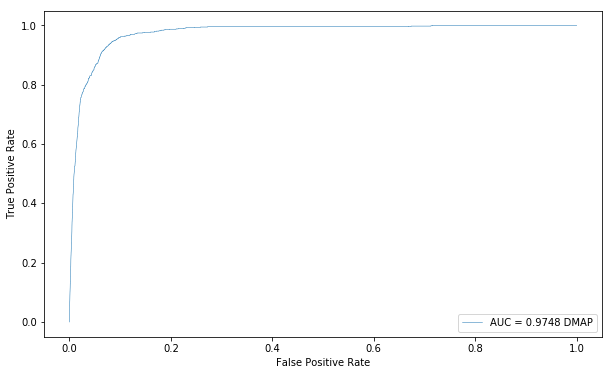

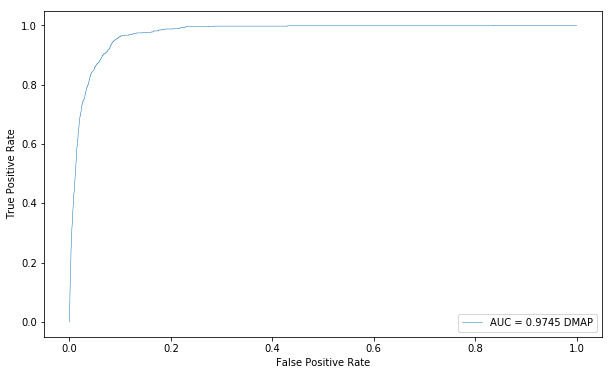

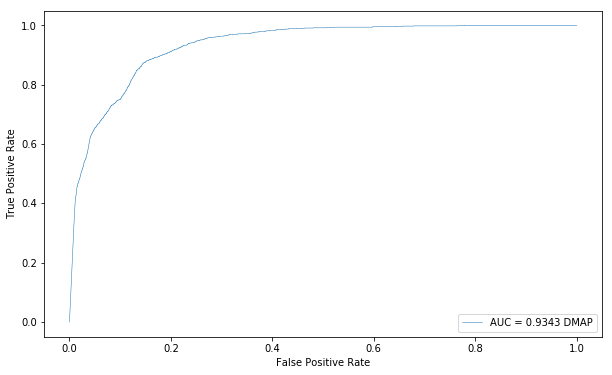

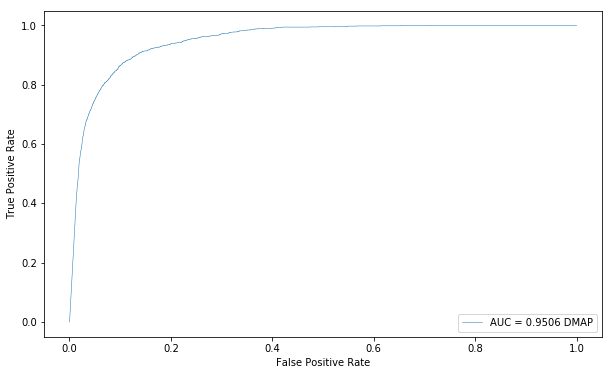

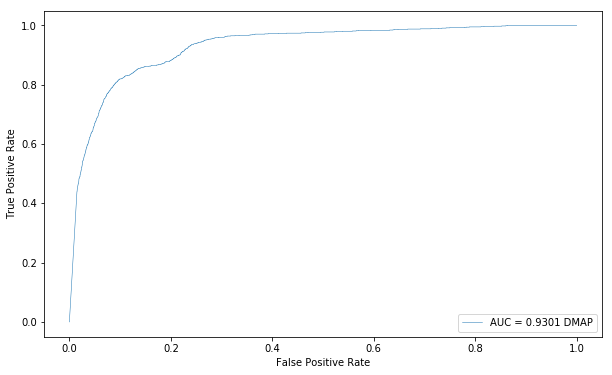

In [30]:
# print the ROC curve

k_fold = 5
for index in range(k_fold):
    label_list = []
    predictProb_list = []
    cur = index
    while cur < len(Test_label_list):
        fold_label = Test_label_list[cur]
        fold_label = (np.array(fold_label)>0).astype(int).tolist()
        label_list.append(fold_label)
        predictProb_list.append(Test_predictProb_list[cur])
        cur += k_fold
    
#     print(np.shape(label_list))
#     print(np.shape(predictProb_list))
    plt.figure(figsize=(10,6))
    
    feat_name = ['DMAP']
    for idx, label, predictProb in zip(range(len(feat_columns)), label_list, predictProb_list):
        
        fpr, tpr, threshold = sk_metrics.roc_curve(label, predictProb)
#         roc_auc = sk_metrics.auc(fpr, tpr)
        roc_auc = sk_metrics.roc_auc_score(label, predictProb)
    
        plt.plot(fpr, tpr,lw=0.5, label=('AUC = %0.4f ' %  roc_auc) + feat_name[idx])
        plt.legend(loc = 'lower right')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')

    plt.show()
    print("\n")